In [1]:
%%capture
!pip install umap-learn hdbscan bertopic datasets datamapplot

In [2]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
rapids-dask-dependency 25.6.0 requires dask==2025.5.0, but you have dask 2024.12.1 which is incompatible.
rapids-dask-dependency 25.6.0 requires distributed==2025.5.0, but you have distributed 2024.12.1 which is incompatible.


In [6]:
# 허깅 페이스에서 데이터를 로드합니다.
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# 데이터를 추출합니다.
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

In [8]:
from sentence_transformers import SentenceTransformer

# 각각의 초록에 대한 임베딩을 만듭니다.
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode([str(a) for a in abstracts], show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [9]:
embeddings.shape

(44949, 384)

In [10]:
from umap import UMAP

# 입력 임베딩을 384차원에서 5차원으로 줄입니다.
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42, n_jobs=1
)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [11]:
from hdbscan import HDBSCAN

# 모델을 훈련하고 클러스터를 추출합니다.
hdbscan_model = HDBSCAN(min_cluster_size=50).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# 클러스터 개수를 확인합니다.
len(set(clusters))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


155

In [14]:
import numpy as np

# 클러스터 0에 있는 처음 세 개의 문서를 출력합니다
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [15]:
import pandas as pd

reduced_embeddings = UMAP(
    n_components=2,min_dist = 0.0,metric="cosine", random_state=42
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings,columns = ["x","y"])
df

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,x,y
0,5.100358,-0.149913
1,5.092737,-0.142403
2,4.477305,-0.505342
3,-0.146902,-0.733101
4,4.513205,2.437404
...,...,...
44944,0.062907,-2.893557
44945,3.575017,-1.656726
44946,-0.661639,-1.546832
44947,3.555982,-0.068566


In [16]:
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

In [17]:
df

,x,y,title,cluster
0,5.100358,-0.149913,Introduction to Arabic Speech Recognition Usin...,-1
1,5.092737,-0.142403,Arabic Speech Recognition System using CMU-Sph...,-1
2,4.477305,-0.505342,On the Development of Text Input Method - Less...,-1
3,-0.146902,-0.733101,Network statistics on early English Syntax: St...,-1
4,4.513205,2.437404,Segmentation and Context of Literary and Music...,85
...,...,...,...,...
44944,0.062907,-2.893557,Resolution of Verb Ellipsis in Japanese Senten...,-1
44945,3.575017,-1.656726,An Example-Based Approach to Japanese-to-Engli...,-1
44946,-0.661639,-1.546832,Deduction over Mixed-Level Logic Representatio...,-1
44947,3.555982,-0.068566,HMM Specialization with Selective Lexicalization,133


In [18]:
clusters_df = df.loc[df.cluster!="-1",:]
outliers_df = df.loc[df.cluster=="-1",:]

(np.float64(-8.334335255622864),
 np.float64(11.817492890357972),
 np.float64(-5.973596382141113),
 np.float64(11.185701179504395))

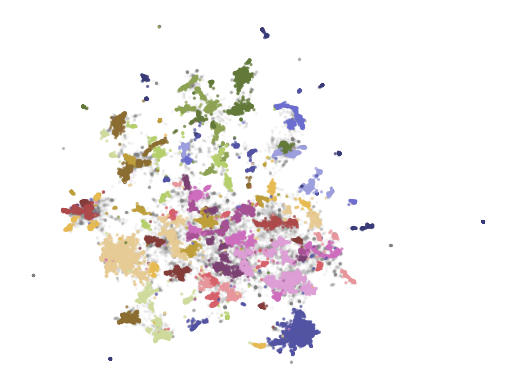

In [21]:
import matplotlib.pyplot as plt
plt.scatter(outliers_df.x,outliers_df.y,alpha = 0.05,s=2,c="grey")
plt.scatter(
    clusters_df.x,clusters_df.y,c = clusters_df.cluster.astype(int),alpha = 0.6,s=2,cmap="tab20b"
)
plt.axis("off")

In [22]:
from bertopic import BERTopic

# 앞서 정의한 모델을 사용해 BERTopic 모델을 훈련합니다.
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-07-18 02:27:22,833 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-18 02:28:19,707 - BERTopic - Dimensionality - Completed ✓
2025-07-18 02:28:19,710 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-18 02:28:25,329 - BERTopic - Cluster - Completed ✓
2025-07-18 02:28:25,342 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-18 02:28:29,406 - BERTopic - Representation - Completed ✓


In [23]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14210,-1_of_the_and_to,"[of, the, and, to, in, we, language, for, that...",[ GPT-$3$ has attracted lots of attention due...
1,0,2316,0_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ The speech chain mechanism integrates autom...
2,1,2183,1_question_qa_questions_answer,"[question, qa, questions, answer, answering, a...",[ Text-based Question Generation (QG) aims at...
3,2,941,2_translation_nmt_machine_bleu,"[translation, nmt, machine, bleu, neural, engl...","[ Recently, the development of neural machine..."
4,3,880,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Sentence summarization shortens given texts...
...,...,...,...,...,...
150,149,54,149_sentence_embeddings_sts_embedding,"[sentence, embeddings, sts, embedding, similar...",[ Sentence representation at the semantic lev...
151,150,54,150_gans_gan_adversarial_generation,"[gans, gan, adversarial, generation, generativ...",[ Text generation is of particular interest i...
152,151,54,151_coherence_discourse_paragraph_text,"[coherence, discourse, paragraph, text, cohesi...",[ While there has been significant progress t...
153,152,53,152_chatgpt_its_openai_tasks,"[chatgpt, its, openai, tasks, has, ai, capabil...","[ Over the last few years, large language mod..."


In [25]:
topic_model.get_topic(0)

[('speech', np.float64(0.028208883288593535)),
 ('asr', np.float64(0.018842312810416793)),
 ('recognition', np.float64(0.01351959051292077)),
 ('end', np.float64(0.009745990895354896)),
 ('acoustic', np.float64(0.009384710004108402)),
 ('speaker', np.float64(0.006877359138616964)),
 ('audio', np.float64(0.006785262733110495)),
 ('the', np.float64(0.006370412745274845)),
 ('error', np.float64(0.00634287314665723)),
 ('automatic', np.float64(0.0063065026437668335))]

In [26]:
topic_model.find_topics("topic modeling")

([24, -1, 38, 32, 84],
 [np.float32(0.9545274),
  np.float32(0.9123676),
  np.float32(0.9080541),
  np.float32(0.9053283),
  np.float32(0.90453553)])

In [27]:
topic_model.get_topic(24)

[('topic', np.float64(0.06811153301756999)),
 ('topics', np.float64(0.035746717561104396)),
 ('lda', np.float64(0.016020062969070364)),
 ('latent', np.float64(0.013574936227317968)),
 ('documents', np.float64(0.013201698266173009)),
 ('document', np.float64(0.012912590658853182)),
 ('modeling', np.float64(0.012084716289729468)),
 ('dirichlet', np.float64(0.01010281253111858)),
 ('word', np.float64(0.008653858081603273)),
 ('allocation', np.float64(0.007950503995528465))]

In [28]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

24

In [30]:
fig = topic_model.visualize_documents(
    [str(title) for title in titles],
    reduced_embeddings = reduced_embeddings,
    width = 1200,
    hide_annotations = True
)

fig.update_layout(font=dict(size=16))

Output hidden; open in https://colab.research.google.com to view.

In [31]:
topic_model.visualize_barchart()

In [32]:
topic_model.visualize_heatmap(n_clusters=30)

In [33]:
topic_model.visualize_hierarchy()

In [ ]:
# 원본 표현을 복사합니다.
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [ ]:
def topic_differences(model, original_topics, nr_topics=5):
    """두 모델의 토픽 표현 차이를 보여줍니다"""
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # 모델과 토픽마다 상위 5개 단어를 추출합니다.
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

In [ ]:
from bertopic.representation import KeyBERTInspired

# KeyBERTInspired를 사용해 토픽 표현을 업데이트합니다.
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)

In [1]:
from bertopic.representation import MaximalMarginalRelevance

# MaximalMarginalRelevance를 사용해 토픽 표현을 업데이트합니다.
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)

ModuleNotFoundError: No module named 'bertopic'

In [2]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

ModuleNotFoundError: No module named 'bertopic'

In [ ]:
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

In [ ]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

client = openai.OpenAI(api_key = )

In [ ]:
# 토픽과 문서를 시각화합니다.
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    datamap_kwds={
    'label_wrap_width': 20,
    'use_medoids': True,
    'label_font_size': 11
    }
)
plt.savefig("datamapplot.png", dpi=300)